# IMPORT REQUIRED MODULES

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# LOAD DATA

In [ ]:
df_train = pd.read_csv("train.csv", sep = ";")
df_test = pd.read_csv("test.csv", sep = ";")

In [3]:
df_legend = pd.concat([df_train, df_test], ignore_index = True)

In [4]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# PREPROCESS THE DATA

## STEP 1: DROP DUPLICATES

In [6]:
df_train.drop_duplicates(inplace = True)
df_test.drop_duplicates(inplace = True)

## STEP 2: FILL MISSING DATA OR NaN VALUES

In [7]:
for col in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[col]):
        df_train[col] = df_train[col].fillna(df_train[col].median())
    else:
        df_train[col] = df_train[col].fillna("unknown")

for col in df_test.columns:
    if pd.api.types.is_numeric_dtype(df_test[col]):
        df_test[col] = df_test[col].fillna(df_test[col].median())
    else:
        df_test[col] = df_test[col].fillna("unknown")

## STEP 3: DISREGARD THE SPECIAL CHARACTERS IN THE TEXT FIELDS, IF ANY

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z09\s]", "", text)
    return text

## STEP 4: Apply one-hot encoding to categorical columns in the training and test sets, 
## dropping the first category to avoid the dummy variable trap

In [9]:
df_train_encoded = pd.get_dummies(df_train, drop_first = True)
df_test_encoded = pd.get_dummies(df_test, drop_first = True)

In [10]:
df_train_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,44,29,5,151,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2,33,2,5,76,1,-1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
3,47,1506,5,92,1,-1,0,True,False,False,...,False,False,True,False,False,False,False,False,True,False
4,33,1,5,198,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [11]:
df_test_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,30,1787,19,79,1,-1,0,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1,33,4789,11,220,1,339,4,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,35,1350,16,185,1,330,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,1476,3,199,4,-1,0,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,59,0,5,226,1,-1,0,True,False,False,...,False,False,True,False,False,False,False,False,True,False


## STEP 5: CHECK FOR NULL VALUES IN THE ENCODED DATA

In [12]:
df_train_encoded.isna().sum()

age                    0
balance                0
day                    0
duration               0
campaign               0
pdays                  0
previous               0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_married        0
marital_single         0
education_secondary    0
education_tertiary     0
education_unknown      0
default_yes            0
housing_yes            0
loan_yes               0
contact_telephone      0
contact_unknown        0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0
month_may              0
month_nov              0
month_oct              0
month_sep              0
poutcome_other         0


## STEP 6: COMBINE THE ENCODED TRAIN AND TEST DATA INTO ONE DATAFRAME

In [13]:
df2 = pd.concat([df_train_encoded, df_test_encoded], ignore_index = True)
df2.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,44,29,5,151,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2,33,2,5,76,1,-1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
3,47,1506,5,92,1,-1,0,True,False,False,...,False,False,True,False,False,False,False,False,True,False
4,33,1,5,198,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [14]:
df2.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [15]:
df2.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')

## STEP 7: Remove columns with less useful or less relevant categories from the dataframe

In [16]:
df2 = df2.drop(['job_unknown'], axis=1)
df2 = df2.drop(['education_unknown'], axis=1)
df2 = df2.drop(['contact_unknown'], axis=1)
df2 = df2.drop(['poutcome_unknown'], axis=1)
df2 = df2.drop(['poutcome_other'], axis=1)

In [18]:
df2.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_success', 'y_yes'],
      dtype='object')

# TRAIN AND TEST THE DATA WITH LOGISTIC REGRESSION MODEL AND PRINT RESULTS

In [19]:
target = "poutcome_success"

x = df2.drop(target, axis = 1)
y = df2[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

model = LogisticRegression(max_iter = 9000, solver = "saga")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy : {accuracy : .2f}")


Model Accuracy :  0.97


In [20]:
x_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
49154,45,1757,20,1010,3,326,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48002,32,782,26,116,4,-1,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
30900,32,183,9,17,10,-1,0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
44615,34,625,31,34,1,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5757,32,358,26,396,1,-1,0,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [21]:
x_test.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
40178,39,1241,5,138,2,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18551,31,1030,31,180,5,-1,0,True,False,False,...,False,False,True,False,False,False,False,False,False,False
12486,41,-147,1,130,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
31102,62,5943,17,196,4,-1,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
48520,28,618,7,281,1,-1,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [22]:
y_train.head()

49154    False
48002    False
30900    False
44615    False
5757     False
Name: poutcome_success, dtype: bool

In [23]:
y_test.head()

40178    False
18551    False
12486    False
31102    False
48520    False
Name: poutcome_success, dtype: bool

In [24]:
y_pred_prob = model.predict_proba(x_test)[:, 1]
x_test_prob = x_test.copy()
x_test_prob["pred_prob"] = y_pred_prob

In [25]:
x_test_prob.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes,pred_prob
40178,39,1241,5,138,2,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,0.070801
18551,31,1030,31,180,5,-1,0,True,False,False,...,False,True,False,False,False,False,False,False,False,0.052221
12486,41,-147,1,130,1,-1,0,False,False,False,...,False,True,False,False,False,False,False,False,False,0.073548
31102,62,5943,17,196,4,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,True,0.013153
48520,28,618,7,281,1,-1,0,False,False,False,...,False,False,False,False,True,False,False,False,False,0.084296


In [26]:
df2.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_success', 'y_yes'],
      dtype='object')

In [27]:
x_test_prob.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'y_yes', 'pred_prob'],
      dtype='object')

In [28]:
df_legend.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

# FIT AND TRANSFORM THE MODEL DATA AND FIND THE FEATURE IMPORTANCE BASED ON LOGISTIC REGRESSION COEFFICIENTS

In [29]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model_std = LogisticRegression(max_iter = 9000, solver = "saga")
model_std.fit(x_train_scaled, y_train)

coefs = model_std.coef_[0]
feature_names = x_test.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='AbsCoefficient', ascending = False, inplace = True)

print("Feature importance based on logistic regression coefficients:")
print(coef_df)

Feature importance based on logistic regression coefficients:
                Feature  Coefficient  AbsCoefficient
36                y_yes     0.788014        0.788014
5                 pdays     0.595842        0.595842
4              campaign    -0.565584        0.565584
22          housing_yes    -0.406933        0.406933
6              previous     0.332442        0.332442
23             loan_yes    -0.262130        0.262130
10       job_management    -0.226603        0.226603
3              duration    -0.205907        0.205907
21          default_yes    -0.202245        0.202245
20   education_tertiary     0.188675        0.188675
7       job_blue-collar    -0.187263        0.187263
8      job_entrepreneur    -0.177174        0.177174
17      marital_married     0.151920        0.151920
18       marital_single     0.142776        0.142776
33            month_nov     0.123385        0.123385
2                   day    -0.118705        0.118705
13         job_services    -0.116222 

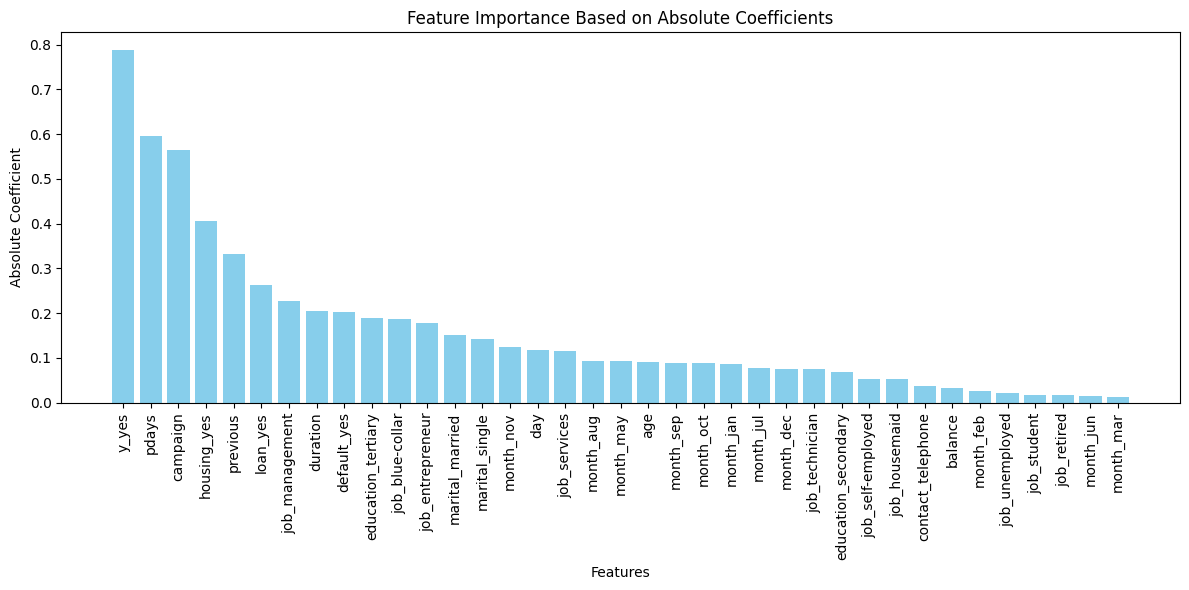

In [30]:
plt.figure(figsize = (12, 6))
plt.bar(coef_df['Feature'], coef_df['AbsCoefficient'], color = 'skyblue')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient')
plt.title('Feature Importance Based on Absolute Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# TRAIN AND TEST THE DATA WITH XGB CLASSIFIER MODEL AND PRINT RESULTS

XGBoost Model Accuracy: 0.98


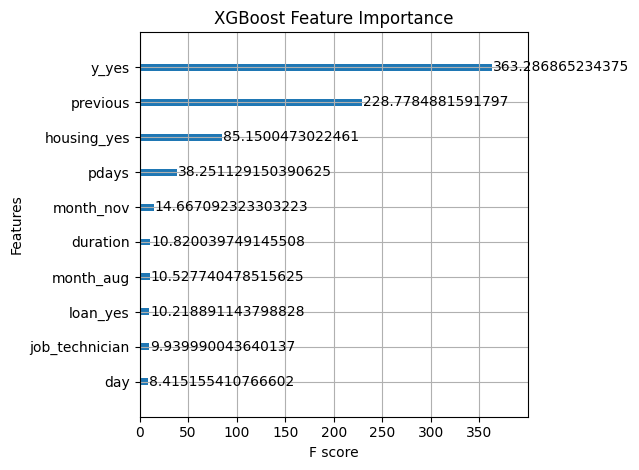

In [31]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Learning rate
    max_depth=3,            # Maximum tree depth
    random_state=42,
    eval_metric='logloss'     # Evaluation metric
)

xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Model Accuracy: {:.2f}".format(accuracy_xgb))

y_pred_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]
x_test_prob_xgb = x_test.copy()
x_test_prob_xgb["pred_prob"] = y_pred_prob_xgb

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [32]:
x_test_prob_xgb.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes,pred_prob
40178,39,1241,5,138,2,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,0.000078
18551,31,1030,31,180,5,-1,0,True,False,False,...,False,True,False,False,False,False,False,False,False,0.000071
12486,41,-147,1,130,1,-1,0,False,False,False,...,False,True,False,False,False,False,False,False,False,0.000079
31102,62,5943,17,196,4,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,True,0.000060
48520,28,618,7,281,1,-1,0,False,False,False,...,False,False,False,False,True,False,False,False,False,0.000084


# COMPARE THE PERFORMANCE OF BOTH MODELS

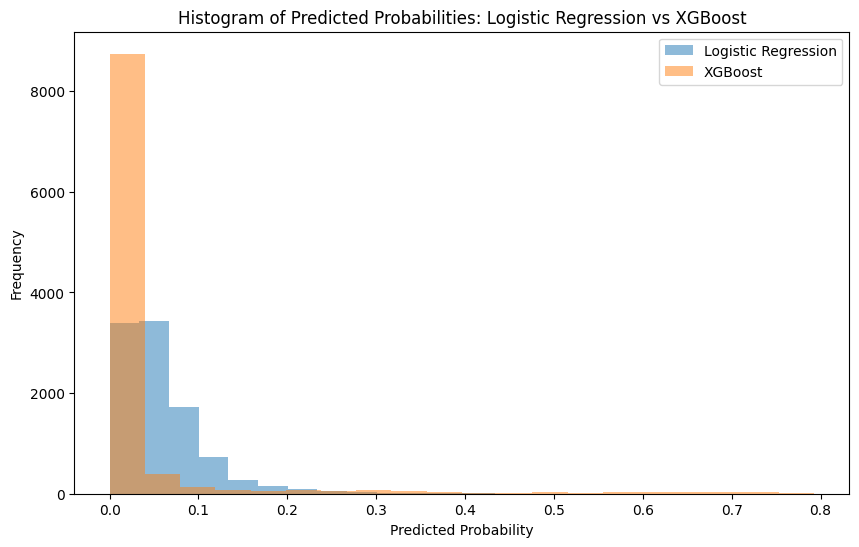

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob, bins=20, alpha=0.5, label='Logistic Regression')
plt.hist(y_pred_prob_xgb, bins=20, alpha=0.5, label='XGBoost')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities: Logistic Regression vs XGBoost')
plt.legend()
plt.show()

In [34]:
x_test_prob_xgb.sort_values(by='pred_prob', ascending = False, inplace = True)

In [35]:
x_test_prob_xgb.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes,pred_prob
48387,28,4745,12,360,1,181,5,False,False,False,...,False,False,False,False,True,False,False,False,True,0.792852
44406,63,3904,4,250,2,187,2,False,True,False,...,False,False,False,False,False,False,False,False,True,0.787422
46392,34,1076,12,152,1,182,6,False,False,False,...,False,False,False,False,True,False,False,False,True,0.779763
41937,68,2144,22,277,1,184,2,False,False,False,...,False,False,False,False,False,False,True,False,True,0.779195
41951,76,2991,22,344,1,183,1,False,False,False,...,False,False,False,False,False,False,True,False,True,0.779195


In [36]:
x_test_prob_xgb.shape

(9947, 38)

In [37]:
x_test_prob_xgb.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'y_yes', 'pred_prob'],
      dtype='object')

In [38]:
# Suppose df is your full DataFrame with a 'pred_prob' column.
# First, filter for high-probability customers.
high_prob = x_test_prob_xgb[x_test_prob_xgb['pred_prob'] > 0.72].copy()

# List of target features.
features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Dictionary to store the common range (IQR) for each feature.
common_ranges = {}

# Remove outliers from each feature using the 1.5 * IQR rule.
for col in features:
    Q1 = high_prob[col].quantile(0.25)
    Q3 = high_prob[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Save the common range (the IQR)
    common_ranges[col] = (Q1, Q3)
    
    # Remove outliers for this feature.
    high_prob = high_prob[(high_prob[col] >= lower_bound) & (high_prob[col] <= upper_bound)]

# Display the most common range for each feature.
print("Most common ranges (IQR) for each feature:")
for col, rng in common_ranges.items():
    print(f"{col}: {rng}")

Most common ranges (IQR) for each feature:
age: (np.float64(34.75), np.float64(64.25))
balance: (np.float64(547.25), np.float64(3530.25))
day: (np.float64(9.0), np.float64(17.5))
duration: (np.float64(244.75), np.float64(423.0))
campaign: (np.float64(1.0), np.float64(2.0))
pdays: (np.float64(181.0), np.float64(183.0))
previous: (np.float64(1.0), np.float64(4.0))


In [39]:
# Define the list of columns to consider
columns_list = [
    'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 
    'job_management', 'job_retired', 'job_self-employed', 'job_services',
    'job_student', 'job_technician', 'job_unemployed', 'marital_married',
    'marital_single', 'education_secondary', 'education_tertiary',
    'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
    'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
    'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
    'month_sep', 'y_yes'
]

# Filter the DataFrame for rows where 'pred_prob' > 0.72
filtered_df = x_test_prob_xgb[x_test_prob_xgb['pred_prob'] > 0.72]

# Create a dictionary to store counts for each column
counts = {}

# For each column in the list, count the rows where the column is True (or 1)
for col in columns_list:
    if col in filtered_df.columns:
        # If the column is numeric (0/1) or boolean, this will work.
        # If the column is a string, you might need to map it to a boolean.
        count_true = filtered_df[col].astype(bool).sum()
        counts[col] = count_true

# Print the counts
print("Counts for each column where pred_prob > 0.72 and the column is True:")
for col, count in counts.items():
    print(f"{col}: {count}")

Counts for each column where pred_prob > 0.72 and the column is True:
job_blue-collar: 4
job_entrepreneur: 2
job_housemaid: 1
job_management: 5
job_retired: 13
job_self-employed: 0
job_services: 2
job_student: 2
job_technician: 8
job_unemployed: 3
marital_married: 29
marital_single: 11
education_secondary: 17
education_tertiary: 18
default_yes: 0
housing_yes: 0
loan_yes: 0
contact_telephone: 7
month_aug: 7
month_dec: 0
month_feb: 4
month_jan: 1
month_jul: 3
month_jun: 3
month_mar: 2
month_may: 5
month_nov: 0
month_oct: 7
month_sep: 9
y_yes: 44


In [40]:
# Define the counts dictionary based on your extracted data
counts = {
    'job_blue-collar': 4,
    'job_entrepreneur': 2,
    'job_housemaid': 1,
    'job_management': 5,
    'job_retired': 13,
    'job_self-employed': 0,
    'job_services': 2,
    'job_student': 2,
    'job_technician': 8,
    'job_unemployed': 3,
    'marital_married': 29,
    'marital_single': 11,
    'education_secondary': 17,
    'education_tertiary': 18,
    'default_yes': 0,
    'housing_yes': 0,
    'loan_yes': 0,
    'contact_telephone': 7,
    'month_aug': 7,
    'month_dec': 0,
    'month_feb': 4,
    'month_jan': 1,
    'month_jul': 3,
    'month_jun': 3,
    'month_mar': 2,
    'month_may': 5,
    'month_nov': 0,
    'month_oct': 7,
    'month_sep': 9
}

def get_max_category(counts, prefix):
    # Filter the dictionary for keys starting with the prefix
    filtered = {k: v for k, v in counts.items() if k.startswith(prefix)}
    if filtered:
        # Find the key with the maximum count
        max_key = max(filtered, key=filtered.get)
        return max_key, filtered[max_key]
    else:
        return None, None

# Extract the maximum for each category
max_job, job_count = get_max_category(counts, 'job_')
max_marital, marital_count = get_max_category(counts, 'marital_')
max_education, education_count = get_max_category(counts, 'education_')
max_month, month_count = get_max_category(counts, 'month_')

print("Most common job:", max_job, "with count:", job_count)
print("Most common marital status:", max_marital, "with count:", marital_count)
print("Most common education:", max_education, "with count:", education_count)
print("Most common month:", max_month, "with count:", month_count)

Most common job: job_retired with count: 13
Most common marital status: marital_married with count: 29
Most common education: education_tertiary with count: 18
Most common month: month_sep with count: 9


Now if the data we get is in this:

age: (np.float64(34.75), np.float64(64.25))
balance: (np.float64(547.25), np.float64(3530.25))
day: (np.float64(9.0), np.float64(17.5))
duration: (np.float64(244.75), np.float64(423.0))
campaign: (np.float64(1.0), np.float64(2.0))
pdays: (np.float64(181.0), np.float64(183.0))
previous: (np.float64(1.0), np.float64(4.0))

range and has got:

job as retired, marriage as married, education as tertiary and last contacted month of year as september

Then that is Our Guy and We will be sending personalized data using genai prompt and the Guy's data as per datasheet.

***(It is yet to be done. We need to learn more about using such models using apis)***

In [ ]:

import requests

# Claude 2 API Configuration
API_KEY = "your_api_key_here"
API_URL = "https://api.anthropic.com/v1/messages"
HEADERS = {
    "x-api-key": API_KEY,
    "Content-Type": "application/json",
    "anthropic-version": "2023-06-01"
}

def get_marketing_strategy(predictions, customer_data):
    prompt = f"""Given the following customer segmentation and predictions: {predictions},
    and customer data: {customer_data}, suggest the best target audience, marketing channels, and messaging strategy."""
    
    data = {
        "model": "claude-2",
        "max_tokens": 300,
        "messages": [
            {"role": "system", "content": "You are a marketing strategist."},
            {"role": "user", "content": prompt}
        ]
    }
    
    response = requests.post(API_URL, headers=HEADERS, json=data).json()
    return response.get("message", {}).get("content", "No response")

# Example Usage
predictions = ["High Conversion Likelihood", "Low Engagement"]  # Example outputs from ML models
customer_data = {"age_group": "25-34", "preferred_channel": "Social Media"}  # Example customer insights

strategy = get_marketing_strategy(predictions, customer_data)
print("Marketing Strategy Recommendation:", strategy)
